In [3]:
import json
import pystac
import stackstac
import os
import xarray as xr
import geopandas as gpd
from shapely import Polygon
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rio
from rasterio.crs import CRS
import rasterio 
import matplotlib.patches as mpatches
import numpy as np

## Utility fns

In [4]:
def check_orig_files(item):
    
    file_ls = ['orig_file_dis_az', 'orig_file_dis_mag','orig_file_dis_N_ang','orig_file_dis_r']
    
    dt_ls, ref_date_ls, sec_date_ls = [],[],[]
    for file in file_ls:
        
        var_name_dt = f'{file}_datetime'
        var_name_ref = f'{file}_ref_date'
        var_name_sec = f'{file}_sec_date'
        
        var_name_dt = item.extra_fields[file][22:30]
        var_name_ref = item.extra_fields[file].split('+S1_')[1][:15]
        var_name_sec = item.extra_fields[file].split('+S1_')[1].split('_')[9]
        
        dt_ls.append(var_name_dt)
        ref_date_ls.append(var_name_ref)
        sec_date_ls.append(var_name_sec)
       
    if len(set(dt_ls)) != 1:
           print('issue w dt')
    elif len(set(ref_date_ls)) != 1:
             print('issue with ref date')
             
    elif len(set(sec_date_ls)) != 1:
             print('issue w sec date')

In [5]:
def get_footprint(ds):
    ''' returns a geopandas geodataframe with the outline of an xarray object.
    xr object must have crs formatted (ie ds.crs returns epsg code)
    '''
    
    left = ds.x.data.min()
    right = ds.x.data.max()
    bottom = ds.y.data.min()
    top = ds.y.data.max()

    bbox = [left, bottom, right, top]
    
    footprint = Polygon([
                [bbox[0], bbox[1]],
                [bbox[0], bbox[3]],
                [bbox[2], bbox[3]],
                [bbox[2], bbox[1]]
                ])
    
    gdf = gpd.GeoDataFrame(index=[0], crs = ds.crs, geometry = [footprint])
    
    return gdf
    
    

## Read in STAC catalog, explore metadata

In [6]:
catalog = pystac.Catalog.from_file('/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/stac_catalog/catalog.json')


In [7]:
catalog

"ID: RETREAT data, Langtang"
Description: NEW RETREAT velocity data for glaciers in Langtang region of Nepal/Tibet
type: Catalog
https://stac-extensions.github.io/projection/v1.0.0/schema.json
ID: 10_085_053_20210113
"Bounding Box: [83.90435612095534, 27.316552327766512, 86.84688658910103, 29.3949542892891]"
Datetime: 2021-01-13 00:00:00+00:00
tile: 10_085_053
sensor: S1
acq_date: 20210107T122220
acq_id: BFF8


In [8]:
items = list(catalog.get_all_items())

In [9]:
for item in items:
    
    check_orig_files(item)

In [10]:
feature_coll = [item.to_dict() for item in items]

In [11]:
gdf = gpd.GeoDataFrame.from_features(feature_coll)

In [12]:
gdf = gdf.set_crs('EPSG:4326')
gdf_prj = gdf.to_crs('EPSG:32645')

<AxesSubplot: >

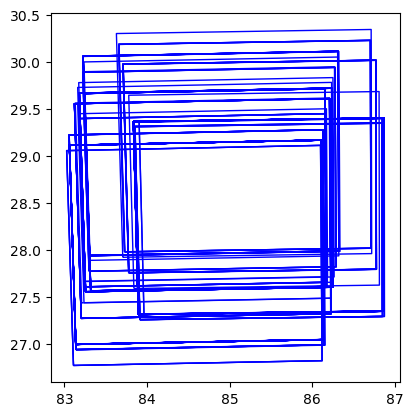

In [13]:
gdf.plot(facecolor='None', edgecolor='blue')

In [14]:
catalog

"ID: RETREAT data, Langtang"
Description: NEW RETREAT velocity data for glaciers in Langtang region of Nepal/Tibet
type: Catalog
https://stac-extensions.github.io/projection/v1.0.0/schema.json
ID: 10_085_053_20210113
"Bounding Box: [83.90435612095534, 27.316552327766512, 86.84688658910103, 29.3949542892891]"
Datetime: 2021-01-13 00:00:00+00:00
tile: 10_085_053
sensor: S1
acq_date: 20210107T122220
acq_id: BFF8


## Explore RETREAT data

In [15]:
cube = stackstac.stack(
    items = [item.to_dict() for item in items])

In [16]:
cube

<xarray.DataArray 'stackstac-0652ae9eeae23dbd53d53c18a8b241d8' (time: 314,
                                                                band: 5,
                                                                y: 1951, x: 1875)>
dask.array<fetch_raster_window, shape=(314, 5, 1951, 1875), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/17)
  * time       (time) datetime64[ns] 2014-10-23 2014-10-31 ... 2021-11-05
    id         (time) <U19 '10_085_002_20141023' ... '10_019_085_20211105'
  * band       (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
  * x          (x) float64 1.128e+05 1.13e+05 1.132e+05 ... 4.874e+05 4.876e+05
  * y          (y) float64 3.357e+06 3.357e+06 3.357e+06 ... 2.967e+06 2.967e+06
    acq_id     (time) <U4 '8496' 'C51B' 'C035' 'D1BD' ... 'C779' 'D64B' '85AD'
    ...         ...
    frame      (time) <U3 '085' '019' '019' '085' ... '019' '019' '019' '019'
    site       <U2 '10'
    tile       (time) <U10 '10_085_002' '10_019_001' ... '10_019_085'
    proj:epsg  int64 32645
    title      (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
    epsg       int64 32645
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    crs:         epsg:32645
    transform:   | 200.00, 0.00, 112800.00|\n| 0.00,-200.00, 3357000.00|\n| 0...
    resolution:  200.0

In [17]:
cube.isel(time=1)

<xarray.DataArray 'stackstac-0652ae9eeae23dbd53d53c18a8b241d8' (band: 5,
                                                                y: 1951, x: 1875)>
dask.array<getitem, shape=(5, 1951, 1875), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/17)
    time       datetime64[ns] 2014-10-31
    id         <U19 '10_019_001_20141031'
  * band       (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
  * x          (x) float64 1.128e+05 1.13e+05 1.132e+05 ... 4.874e+05 4.876e+05
  * y          (y) float64 3.357e+06 3.357e+06 3.357e+06 ... 2.967e+06 2.967e+06
    acq_id     <U4 'C51B'
    ...         ...
    frame      <U3 '019'
    site       <U2 '10'
    tile       <U10 '10_019_001'
    proj:epsg  int64 32645
    title      (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
    epsg       int64 32645
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    crs:         epsg:32645
    transform:   | 200.00, 0.00, 112800.00|\n| 0.00,-200.00, 3357000.00|\n| 0...
    resolution:  200.0

In [18]:
cube.isel(time=0).sel(band='dis_mag').mean().compute().data

array(0.02581397)

### Verify against ind file

In [19]:
#dismag_10232014 = xr.open_dataset('/home/emmamarshall/Desktop/phd_work/retreat/data/10_085_002/10_085_002_20141023-dis_mag+S1_20141011T122155_8496_1_10_1_10_1_10_S1_20141104T122155_D1BD_1_10_1_10_1_10+250-50_50-10_0.00-0.08_2_geo_filtered_corrected.tif').squeeze()

In [20]:
#dismag_10232014.band_data.mean()

## Other data

### UTM

In [67]:
utm_grid = gpd.read_file('/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/data/utm/World_UTM_Grid(1).geojson')

### RGI

In [21]:
rgi_path = '/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/data/rgi/'

In [22]:
rgi15 = gpd.read_file(os.path.join(rgi_path, 'rgi15/15_rgi60_SouthAsiaEast.shp'))

In [23]:
rgi15_prj = rgi15.to_crs('EPSG:32645')

In [24]:
rgi_ids = pd.read_csv('/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/data/manuscript_rgi_ids.csv', )

#lake_ids = ['RGI60-15.10255', 'RGI60-15.10285', 'RGI60-15.10279','RGI60-15.10286',
#            'RGI60-15.09361','RGI60-15.09483','RGI60-15.10290','RGI60-15.10299']

Subset all glaciers that lie in the retreat footprint:

In [25]:
cube_footprint = get_footprint(cube)

NameError: name 'rgi_subset' is not defined

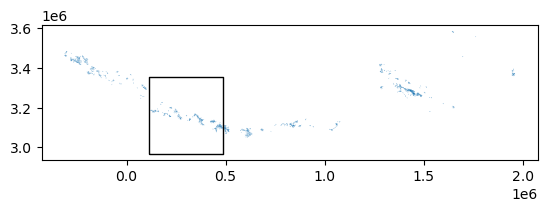

In [26]:
fig, ax = plt.subplots()

#gdf_prj.plot(facecolor='None', edgecolor='blue', ax=ax)
rgi15_prj.plot(ax=ax)
cube_footprint.plot(ax=ax, facecolor='None')
rgi_subset.plot(ax=ax, color='red')

In [68]:
rgi_outlines = gpd.sjoin(rgi15_prj, cube_footprint, how = 'inner')

In [69]:
rgi_outlines.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,index_right
93,RGI60-15.03417,G086756E28007N,20001030,-9999999,86.755809,28.006816,15,2,12.604,5003,...,9530,0,0,0,0,9,9,NaN,"POLYGON ((476794.384 3101234.215, 476827.026 3...",0
94,RGI60-15.03422,G086581E28097N,20001030,-9999999,86.580879,28.097187,15,2,27.163,4787,...,15952,0,0,0,0,9,9,NaN,"POLYGON ((459114.490 3109431.982, 459166.038 3...",0
95,RGI60-15.03428,G086508E27942N,20001030,-9999999,86.507713,27.941942,15,2,13.294,4600,...,5311,0,0,0,0,9,9,NaN,"POLYGON ((451052.278 3085634.324, 451052.278 3...",0
96,RGI60-15.03435,G086541E27955N,20001030,-9999999,86.540768,27.955112,15,2,5.911,4849,...,5969,0,0,0,0,9,9,NaN,"POLYGON ((453806.729 3093891.223, 453856.436 3...",0
97,RGI60-15.03448,G086534E27875N,20001030,-9999999,86.533994,27.874675,15,2,28.574,4577,...,17977,0,0,0,0,9,9,NaN,"POLYGON ((453914.728 3090868.836, 453948.485 3...",0


In [70]:
rgi_ids = rgi_outlines['RGIId'].to_list()

In [71]:
len(rgi_ids)

118

In [72]:
rgi_outlines.crs

<Derived Projected CRS: EPSG:32645>
Name: WGS 84 / UTM zone 45N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°E and 90°E, northern hemisphere between equator and 84°N, onshore and offshore. Bangladesh. Bhutan. China. India. Kazakhstan. Mongolia. Nepal. Russian Federation.
- bounds: (84.0, 0.0, 90.0, 84.0)
Coordinate Operation:
- name: UTM zone 45N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Centerlines

from cryosphere paper

In [31]:
centerline_dir_path = '/uufs/chpc.utah.edu/common/home/u1269862/2022/'

In [33]:
sa_13_ablationlines = gpd.read_file(os.path.join(centerline_dir_path,'zhang_lower_centerlines/13_rgi60_CentralAsia_Ablationlines.shp')).to_crs('EPSG:4326')
sa_14_ablationlines = gpd.read_file(os.path.join(centerline_dir_path,'zhang_lower_centerlines/14_rgi60_SouthAsiaWest_Ablationlines.shp')).to_crs('EPSG:4326')
sa_15_ablationlines = gpd.read_file(os.path.join(centerline_dir_path, 'zhang_lower_centerlines/15_rgi60_SouthAsiaEast_Ablationlines.shp')).to_crs('EPSG:4326')

In [43]:
ablation_lines = pd.concat([sa_13_ablationlines, sa_14_ablationlines, sa_15_ablationlines])

subset only the ones in single utm zone (32645 to start)

In [76]:
ablation_lines_32645 = gpd.sjoin(ablation_lines, utm_grid.loc[utm_grid['ZONE'] == 45], how='inner')

In [77]:
ablation_lines_32645_prj = ablation_lines_32645.to_crs('EPSG:32645')

In [80]:
#rgi_outlines = rgi_outlines.drop('index_right',axis=1)

In [83]:
#ablation_lines_32645_prj = ablation_lines_32645_prj.drop('index_right', axis=1)

In [84]:
rgi_outlines_wcenterlines = gpd.sjoin(rgi_outlines, ablation_lines_32645_prj, how='inner')

<AxesSubplot: >

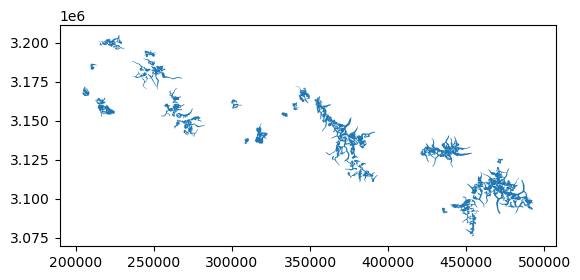

In [86]:
rgi_subset_wcenterlines.plot()

Want to have a df with outlines, and one with centerlines for the 90 glaciers

In [88]:
#drop outline geometry
rgi_subset_centerlines = rgi_subset_wcenterlines.drop('geometry', axis=1)

In [93]:
ablation_lines_32645_prj = ablation_lines_32645_prj.rename({'GLIMS_ID':'GLIMSId'}, axis=1)

In [94]:
rgi_subset_centerlines = rgi_subset_centerlines.merge(ablation_lines_32645_prj, on='GLIMSId')

In [96]:
rgi_subset_centerlines = rgi_subset_centerlines.iloc[:, :-6]

In [99]:
type(rgi_subset_centerlines)

pandas.core.frame.DataFrame

### NASADEM

In [38]:
nasadem_dir = '/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/data/nasadem/'

In [57]:
#nasadem_ls = os.listdir(nasadem_dir)
#nasadem_ls = [item for item in nasadem_ls if '.ipynb' not in item]

In [39]:
nasadem = xr.open_dataset(os.path.join(nasadem_dir,  'NASADEM_NC_n28e085.nc'))

In [40]:
nasadem = nasadem.rio.write_crs('EPSG:4326')

In [41]:
nasadem_prj = nasadem.rio.reproject('EPSG:32645')

In [42]:
nasadem_prj

<xarray.Dataset>
Dimensions:      (x: 3419, y: 3859)
Coordinates:
  * x            (x) float64 3.033e+05 3.034e+05 ... 4.026e+05 4.026e+05
  * y            (y) float64 3.21e+06 3.21e+06 3.21e+06 ... 3.098e+06 3.098e+06
    crs          int64 0
Data variables:
    NASADEM_HGT  (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    history:                   Sat Aug 25 09:28:18 2018: /usr/bin/ncpdq -O -a...
    nco_openmp_thread_number:  1
    GDAL_AREA_OR_POINT:        Point
    Conventions:               CF-1.5
    GDAL:                      GDAL 2.2.0dev, released 2016/99/99
    NCO:                       4.3.7

In [48]:
#dem_path_ls = [os.path.join(nasadem_dir, item) for item in nasadem_ls]

In [49]:
#ds = xr.open_dataset(dem_path_ls[0])

In [50]:
#xr_dem_ls = []

#for element in range(len(dem_path_ls)):
    
#    ds = xr.open_dataset(dem_path_ls[element])
#    xr_dem_ls.append(ds)

In [51]:
#for element in range(len(xr_dem_ls)):
    
#    xr_dem_ls[element] = xr_dem_ls[element].rio.write_crs('EPSG:4326')
#    xr_dem_ls[element] = xr_dem_ls[element].rename({'lon':'x','lat':'y'})

In [52]:
#from rioxarray import merge

In [53]:
#merged_dem = merge.merge_datasets(xr_dem_ls)

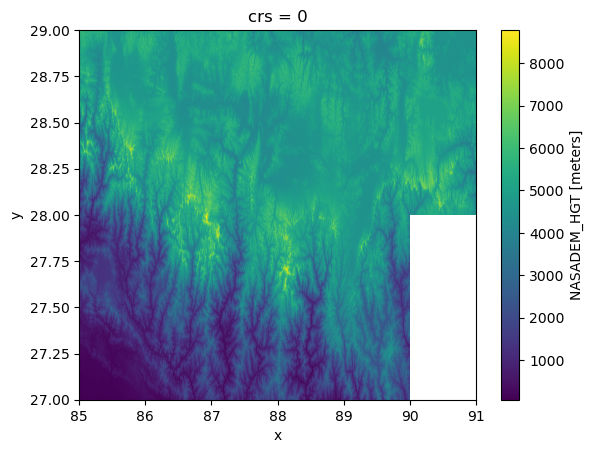

In [105]:
#merged_dem.NASADEM_HGT.plot()

In [107]:
#merged_dem.rio.crs

CRS.from_epsg(4326)

In [48]:
#nasadem_prj_merge = merged_dem.rio.reproject('EPSG:32645')

In [49]:
#nasadem_prj_footprint_merge = get_footprint(nasadem_prj_merge)

In [57]:
#merge_dem_footprint_ll = get_footprint(merged_dem)

In [139]:
#rgi_subset = rgi_subset.drop('index_right',axis=1)

In [143]:
rgi_subset = gpd.sjoin(rgi_subset, nasadem_prj_footprint_merge, how = 'inner')

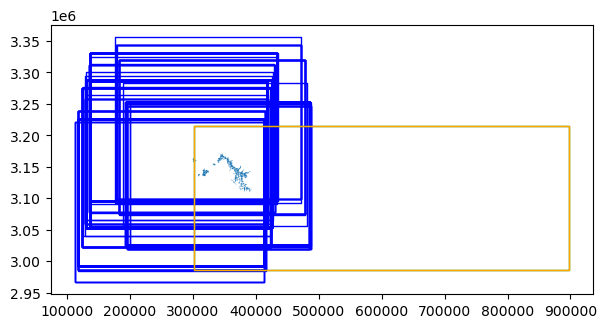

In [145]:
fig, ax = plt.subplots(figsize=(7,7))

#retreat_footprint.plot(ax=ax, facecolor='None', edgecolor='blue')
rgi = rgi_subset.plot(ax=ax, label = 'glacier outlines')
retreat_footprint = gdf_prj.plot(facecolor='None', edgecolor='blue', ax=ax, label = 'retreat data footprints')
dem_footprint = nasadem_prj_footprint.plot(facecolor='None', edgecolor='green',ax=ax, label = 'nasadem footprint')
nasadem_prj_footprint_merge.plot(facecolor='None', edgecolor='orange', ax=ax)

#ax.legend(('RGI','RETREAT','NASADEM'), loc='upper right', shadow=False)
plt.show()

## Ind glacier workflow

### Fns

In [62]:
r03976 = rgi_subset.loc[rgi_subset['RGIId'] == 'RGI60-15.03976']

In [68]:
ds_03976 = cube.rio.clip(r03976.geometry, r03976.crs)

In [64]:
from scipy.stats import sem

In [65]:
def calc_sem(x):
    
    return sem(((x)*365).flatten(), nan_policy='omit')


In [69]:
def clip_glacier_add_dem(rgi_id, rgi_full, retreat_xr, dem_xr): #all in local utm
    
    rgi_single = rgi_full.loc[rgi_full['RGIId'] == rgi_id]
    
    retreat_clip = retreat_xr.rio.clip(rgi_single.geometry, rgi_single.crs)
    
    retreat_clip_ds = retreat_clip.to_dataset(dim='band')
    
    dem_clip = dem_xr.rio.clip(rgi_single.geometry, rgi_single.crs)
    
    dem_downsamp = dem_clip.interp_like(retreat_clip_ds, method = 'nearest')
    
    retreat_clip_ds['sem_mag'] = (('time'), [calc_sem(retreat_clip_ds.isel(time=t).dis_mag.data) for t in range(len(retreat_clip_ds.time))])

    
    
    zmin = np.nanmin(dem_downsamp.NASADEM_HGT.data)
    zq1 = np.nanpercentile(dem_downsamp.NASADEM_HGT.data, 25)
    zmed = np.nanmedian(dem_downsamp.NASADEM_HGT.data)
    zq3 = np.nanpercentile(dem_downsamp.NASADEM_HGT.data, 75)
    zmax = np.nanmax(dem_downsamp.NASADEM_HGT.data)
    
    z0 = dem_downsamp.NASADEM_HGT.where(np.logical_and(dem_downsamp.NASADEM_HGT >= zmin, dem_downsamp.NASADEM_HGT <= zq1), drop=True)
    z1 = dem_downsamp.NASADEM_HGT.where(np.logical_and(dem_downsamp.NASADEM_HGT >= zq1, dem_downsamp.NASADEM_HGT <= zmed), drop=True)
    z2 = dem_downsamp.NASADEM_HGT.where(np.logical_and(dem_downsamp.NASADEM_HGT >= zmed, dem_downsamp.NASADEM_HGT <= zq3), drop=True)
    z3 = dem_downsamp.NASADEM_HGT.where(np.logical_and(dem_downsamp.NASADEM_HGT >= zq3, dem_downsamp.NASADEM_HGT <= zmax), drop=True)
    
    retreat_clip_ds['z0'] = z0
    retreat_clip_ds['z1'] = z1
    retreat_clip_ds['z2'] = z2
    retreat_clip_ds['z3'] = z3
    
    z0_cond_min = retreat_clip_ds.z0.min().data >= zmin
    z0_cond_max = retreat_clip_ds.z0.max().data < zq1+1
    z1_cond_min = retreat_clip_ds.z1.min().data >= zq1
    z1_cond_max = retreat_clip_ds.z1.max().data <zmed + 1
    z2_cond_min = retreat_clip_ds.z2.min().data >= zmed
    z2_cond_max = retreat_clip_ds.z2.max().data < zq3 + 1
    z3_cond_min = retreat_clip_ds.z3.min().data >= zq3
    z3_cond_max = retreat_clip_ds.z3.max().data < zmax+1
    
    cond_ls = [z0_cond_min, z0_cond_max, z1_cond_min, z1_cond_max,
               z2_cond_min, z2_cond_max, z3_cond_min, z3_cond_max]
    
    test = all(i for i in cond_ls)
    
    if test != True:
        
        print('there is an elevation masking issue here')
        
    else:
    
        pass
    
        return retreat_clip_ds

In [70]:
gb_03976 = ds_03976.groupby(ds_03976.time.dt.season).mean()

In [72]:
gb_03976

<xarray.DataArray 'stackstac-f748bcc7b2e0ee6e77bbfcbce39b813c' (season: 4,
                                                                band: 5, y: 19,
                                                                x: 15)>
dask.array<stack, shape=(4, 5, 19, 15), dtype=float64, chunksize=(1, 1, 19, 15), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
  * x            (x) float64 3.08e+05 3.082e+05 ... 3.106e+05 3.108e+05
  * y            (y) float64 3.139e+06 3.138e+06 ... 3.135e+06 3.135e+06
    sensor       <U2 'S1'
    site         <U2 '10'
    title        (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
    proj:epsg    int64 32645
    epsg         int64 32645
    spatial_ref  int64 0
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    resolution:  200.0

In [71]:
gb_03976.where(gb_03976['z0'].notnull(),drop=True)

KeyError: 'z0'

## Seasonal velocity analysis prep

In [ ]:
#retreat_clip_ds['sem_mag'] = (('time'), [calc_sem(retreat_clip_ds.isel(time=t).dis_mag.data) for t in range(len(retreat_clip_ds.time))])


In [73]:
def calc_seasonal_sem_by_z(input_ds, z, var,rgi_id):
    
    gb = input_ds.groupby(input_ds.time.dt.season).mean()
    
    if z == 'full':
        
        winter = gb.sel(season='DJF')['sem_mag'].data
        spring = gb.sel(season='MAM')['sem_mag'].data
        summer = gb.sel(season='JJA')['sem_mag'].data
        fall = gb.sel(season='SON')['sem_mag'].data
    
    else:
        
        z_gb = gb.where(gb[f'{z}'].notnull(), drop=True)
        z_gb['sem_mag'] = (('season'), [calc_sem(z_gb.isel(season=s).dis_mag.data) for s in range(len(z_gb.season))])
        
        winter = z_gb.sel(season='DJF')['sem_mag'].data
        spring = z_gb.sel(season='MAM')['sem_mag'].data
        summer = z_gb.sel(season='JJA')['sem_mag'].data
        fall = z_gb.sel(season='SON')['sem_mag'].data
        
    d = {'RGIId':rgi_id, 'var':var, 'z':z, 'winter': winter,
             'spring':spring, 'summer': summer, 'fall':fall}
            
    df = pd.DataFrame(d, index=[0])
    
    return df
    
        

In [74]:
def calc_seasonal_mean_by_z(input_ds, z, var, rgi_id):
        
    gb = input_ds.groupby(input_ds.time.dt.season).mean()
    
    if z == 'full':

        winter = gb.sel(season='DJF')[f'{var}'].mean(dim=['x','y']).compute().data*365
        spring = gb.sel(season='MAM')[f'{var}'].mean(dim=['x','y']).compute().data*365
        summer = gb.sel(season='JJA')[f'{var}'].mean(dim=['x','y']).compute().data*365
        fall = gb.sel(season='SON')[f'{var}'].mean(dim=['x','y']).compute().data*365

    else:
        z_gb = gb.where(gb[f'{z}'].notnull(), drop=True)

        winter = z_gb.sel(season='DJF')[f'{var}'].mean(dim=['x','y']).compute().data*365
        spring = z_gb.sel(season='MAM')[f'{var}'].mean(dim=['x','y']).compute().data*365
        summer = z_gb.sel(season='JJA')[f'{var}'].mean(dim=['x','y']).compute().data*365
        fall = z_gb.sel(season='SON')[f'{var}'].mean(dim=['x','y']).compute().data*365
    
    d = {'RGIId':rgi_id, 'var': var, 'z':z, 'winter': winter,
             'spring':spring, 'summer': summer, 'fall':fall}
            
    df = pd.DataFrame(d, index=[0])
    
    return df
    

In [75]:
ds_03976 = clip_glacier_add_dem('RGI60-15.03976', rgi_subset, cube, nasadem_prj)
ds_03976

<xarray.Dataset>
Dimensions:      (time: 314, x: 15, y: 19, band: 5)
Coordinates: (12/18)
  * time         (time) datetime64[ns] 2014-10-23 2014-10-31 ... 2021-11-05
  * x            (x) float64 3.08e+05 3.082e+05 ... 3.106e+05 3.108e+05
  * y            (y) float64 3.139e+06 3.138e+06 ... 3.135e+06 3.135e+06
    id           (time) <U19 '10_085_002_20141023' ... '10_019_085_20211105'
    sec_id       (time) <U4 '55_D' '54_1' '3910' '54_C' ... 'F61C' 'D582' '3830'
    orbit        (time) <U3 '002' '001' '010' '002' ... '085' '085' '085' '085'
    ...           ...
    site         <U2 '10'
    title        (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
    proj:epsg    int64 32645
    epsg         int64 32645
    spatial_ref  int64 0
    crs          int64 0
Dimensions without coordinates: band
Data variables:
    dis_ang      (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_az       (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_mag      (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_N_ang    (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_r        (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    sem_mag      (time) float64 2.75 2.352 2.23 5.502 ... 6.296 3.47 3.899 5.173
    z0           (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    z1           (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    z2           (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    z3           (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    resolution:  200.0

In [76]:
groupby_03976 = ds_03976.groupby(ds_03976.time.dt.season).mean()

checking by hand to make sure its all good -- it is, function df below should be correct

In [77]:
winter_z0_dismag = groupby_03976.where(groupby_03976.z0.notnull(), drop=True).sel(season='DJF').dis_mag.mean(dim=['x','y']).compute().data*365
spring_z0_dismag = groupby_03976.where(groupby_03976.z0.notnull(), drop=True).sel(season='MAM').dis_mag.mean(dim=['x','y']).compute().data*365
summer_z0_dismag = groupby_03976.where(groupby_03976.z0.notnull(), drop=True).sel(season='JJA').dis_mag.mean(dim=['x','y']).compute().data*365
fall_z0_dismag = groupby_03976.where(groupby_03976.z0.notnull(), drop=True).sel(season='SON').dis_mag.mean(dim=['x','y']).compute().data*365

print(winter_z0_dismag)
print(spring_z0_dismag)
print(summer_z0_dismag)
print(fall_z0_dismag)

43.500089049598614
56.47553117056695
39.54093994895913
37.496375544561175


In [78]:
dismag_03976 = pd.concat([calc_seasonal_mean_by_z(ds_03976, z,'dis_mag','RGI60-15.03976') for z in ['z0','z1','z2','z3','full']])


In [79]:
sem_03976 = pd.concat([calc_seasonal_sem_by_z(ds_03976,z,'sem_mag','RGI60-15.03976') for z in ['z0','z1','z2','z3','full']])

In [80]:
sem_03976

,RGIId,var,z,winter,spring,summer,fall
0,RGI60-15.03976,sem_mag,z0,2.380409,1.936788,2.244291,2.087588
0,RGI60-15.03976,sem_mag,z1,1.826198,1.535652,2.282830,1.920355
0,RGI60-15.03976,sem_mag,z2,1.792611,1.928023,2.325144,2.899642
0,RGI60-15.03976,sem_mag,z3,1.590953,1.583088,1.023854,1.462376
0,RGI60-15.03976,sem_mag,full,3.475948,4.400401,3.192285,3.049941


In [81]:
dismag_03976

,RGIId,var,z,winter,spring,summer,fall
0,RGI60-15.03976,dis_mag,z0,43.500089,56.475531,39.540940,37.496376
0,RGI60-15.03976,dis_mag,z1,49.016882,58.841267,52.135521,48.825564
0,RGI60-15.03976,dis_mag,z2,39.318271,46.528645,35.179276,41.555888
0,RGI60-15.03976,dis_mag,z3,30.475781,36.574519,22.264561,23.692706
0,RGI60-15.03976,dis_mag,full,41.219584,50.537467,38.228767,38.716398


In [82]:
ds_03976['sem'] = (('time'), [calc_sem(ds_03976.isel(time=t).dis_mag.data) for t in range(len(ds_03976.time))])

In [83]:
def wrapper_single_glacier(rgi_id, rgi_full, retreat_xr, dem_xr, var):
    '''wraps the above two functions, returns a dataframe with seasonal velocities for each elevation quartile
       input args are: rgi_id (str), full or subset rgi gpdf
       retreat xr object (read from stackstac) in local utm,
       NASADEM xr object projected to local utm 
       variable for which you want seasonal means to be calculated
       
   '''
    ds = clip_glacier_add_dem(rgi_id, rgi_full, retreat_xr, dem_xr)
        
    df_mag = pd.concat([calc_seasonal_mean_by_z(ds, z, var, rgi_id) for z in ['z0','z1','z2','z3','full']])
    df_sem = pd.concat([calc_seasonal_sem_by_z(ds, z, 'sem_mag', rgi_id) for z in ['z0', 'z1', 'z2', 'z3', 'full']])
    
    df = pd.concat([df_mag, df_sem])

    return df

In [84]:
df_03976 = wrapper_single_glacier('RGI60-15.03976', rgi_subset, cube, nasadem_prj, 'dis_mag')

In [115]:
df_03976

,RGIId,var,z,winter,spring,summer,fall
0,RGI60-15.03976,dis_mag,z0,43.500089,56.475531,39.540940,37.496376
0,RGI60-15.03976,dis_mag,z1,49.016882,58.841267,52.135521,48.825564
0,RGI60-15.03976,dis_mag,z2,39.318271,46.528645,35.179276,41.555888
0,RGI60-15.03976,dis_mag,z3,30.475781,36.574519,22.264561,23.692706
0,RGI60-15.03976,dis_mag,full,41.219584,50.537467,38.228767,38.716398
0,RGI60-15.03976,sem_mag,z0,2.380409,1.936788,2.244291,2.087588
0,RGI60-15.03976,sem_mag,z1,1.826198,1.535652,2.282830,1.920355
0,RGI60-15.03976,sem_mag,z2,1.792611,1.928023,2.325144,2.899642
0,RGI60-15.03976,sem_mag,z3,1.590953,1.583088,1.023854,1.462376
0,RGI60-15.03976,sem_mag,full,3.475948,4.400401,3.192285,3.049941


In [50]:
df_subset = pd.concat([wrapper_single_glacier(rgi_id, rgi_subset, cube, nasadem_prj, 'dis_mag') for rgi_id in rgi_ids])

NoDataInBounds: No data found in bounds. Data variable: NASADEM_HGT

In [117]:
df_lakes

,RGIId,var,z,winter,spring,summer,fall
0,RGI60-15.10255,dis_mag,z0,22.539492,30.090942,33.527560,24.118777
0,RGI60-15.10255,dis_mag,z1,52.001520,61.924872,59.745272,55.179194
0,RGI60-15.10255,dis_mag,z2,40.360928,45.718517,53.182507,44.498234
0,RGI60-15.10255,dis_mag,z3,29.770160,32.687643,36.220694,34.270674
0,RGI60-15.10255,dis_mag,full,36.047924,42.339570,45.586998,39.397406
...,...,...,...,...,...,...,...
0,RGI60-15.10299,sem_mag,z0,0.461737,0.513469,0.810576,0.623884
0,RGI60-15.10299,sem_mag,z1,0.810415,0.808621,1.468370,0.856126
0,RGI60-15.10299,sem_mag,z2,0.885469,1.102333,1.784747,0.926011
0,RGI60-15.10299,sem_mag,z3,0.862269,0.776329,1.145361,0.741530


In [120]:
df_lands_chunk0 = pd.concat([wrapper_single_glacier(rgi_id, rgi_subset, cube, nasadem_prj, 'dis_mag') for rgi_id in land_ids_chunked[0]])

/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xarray/core/variable.py:292: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xarray/core/variable.py:292: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xarray/core/variable.py:292: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xarray/core/variable.py:292: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xar

In [122]:
df_lands_chunk1 = pd.concat([wrapper_single_glacier(rgi_id, rgi_subset, cube, nasadem_prj, 'dis_mag') for rgi_id in land_ids_chunked[1]])

/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xarray/core/variable.py:292: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xarray/core/variable.py:292: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xarray/core/variable.py:292: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xarray/core/variable.py:292: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xar

In [123]:
df_lands_chunk2 = pd.concat([wrapper_single_glacier(rgi_id, rgi_subset, cube, nasadem_prj, 'dis_mag') for rgi_id in land_ids_chunked[2]])

/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xarray/core/variable.py:292: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xarray/core/variable.py:292: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xarray/core/variable.py:292: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xarray/core/variable.py:292: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xar

In [27]:
#df_lands_chunk3 = pd.concat([wrapper_single_glacier(rgi_id, rgi_subset, cube, nasadem_prj, 'dis_mag') for rgi_id in land_ids_chunked[3]])
#df_lands_chunk3.to_csv('/home/emmamarshall/Desktop/phd_work/retreat/310_seasonal_velocities_LANDS_3.csv')

In [119]:
df_lakes.to_csv('/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/316_seasonal_velocities_lakes.csv')

In [121]:
df_lands_chunk0.to_csv('/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/316_seasonal_velocities_lands_0.csv')

In [124]:
df_lands_chunk1.to_csv('/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/316_seasonal_velocities_lands_1.csv')

In [125]:
df_lands_chunk2.to_csv('/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/316_seasonal_velocities_lands_2.csv')

In [127]:
df_lands_chunk2.loc[df_lands_chunk2['RGIId'] == 'RGI60-15.09457']

,RGIId,var,z,winter,spring,summer,fall
0,RGI60-15.09457,dis_mag,z0,14.408253,18.815205,14.782463,12.648618
0,RGI60-15.09457,dis_mag,z1,19.569980,27.270727,20.914927,20.107146
0,RGI60-15.09457,dis_mag,z2,27.022401,32.974084,21.569969,22.284379
0,RGI60-15.09457,dis_mag,z3,26.672613,34.958493,21.483185,23.318329
0,RGI60-15.09457,dis_mag,full,21.886240,28.464811,19.686303,19.567159
0,RGI60-15.09457,sem_mag,z0,0.307948,0.452891,0.422680,0.263709
0,RGI60-15.09457,sem_mag,z1,1.019074,0.933912,0.728498,0.803872
0,RGI60-15.09457,sem_mag,z2,0.883170,0.821719,0.481579,0.685615
0,RGI60-15.09457,sem_mag,z3,0.694938,1.169427,0.448774,0.500631
0,RGI60-15.09457,sem_mag,full,1.210743,1.518963,0.977812,0.966227


In [128]:
ds_09457 = cube.rio.clip(rgi_subset.loc[rgi_subset['RGIId'] == 'RGI60-15.09457'].geometry, rgi_subset.loc[rgi_subset['RGIId'] == 'RGI60-15.09457'].crs)

In [132]:
ds_09457 = clip_glacier_add_dem('RGI60-15.09457', rgi_subset, cube, nasadem_prj) 


/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/xarray/core/variable.py:292: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)


In [133]:
ds_09457

<xarray.Dataset>
Dimensions:      (time: 314, x: 46, y: 48, band: 5)
Coordinates: (12/18)
  * time         (time) datetime64[ns] 2014-10-23 2014-10-31 ... 2021-11-05
  * x            (x) float64 3.602e+05 3.604e+05 ... 3.69e+05 3.692e+05
  * y            (y) float64 3.137e+06 3.137e+06 ... 3.128e+06 3.128e+06
    id           (time) <U19 '10_085_002_20141023' ... '10_019_085_20211105'
    acq_id       (time) <U4 '8496' 'C51B' 'C035' 'D1BD' ... 'C779' 'D64B' '85AD'
    tile         (time) <U10 '10_085_002' '10_019_001' ... '10_019_085'
    ...           ...
    sec_id       (time) <U4 '55_D' '54_1' '3910' '54_C' ... 'F61C' 'D582' '3830'
    proj:epsg    int64 32645
    title        (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
    epsg         int64 32645
    spatial_ref  int64 0
    crs          int64 0
Dimensions without coordinates: band
Data variables:
    dis_ang      (time, y, x) float64 dask.array<chunksize=(1, 48, 46), meta=np.ndarray>
    dis_az       (time, y, x) float64 dask.array<chunksize=(1, 48, 46), meta=np.ndarray>
    dis_mag      (time, y, x) float64 dask.array<chunksize=(1, 48, 46), meta=np.ndarray>
    dis_N_ang    (time, y, x) float64 dask.array<chunksize=(1, 48, 46), meta=np.ndarray>
    dis_r        (time, y, x) float64 dask.array<chunksize=(1, 48, 46), meta=np.ndarray>
    sem_mag      (time) float64 0.9194 1.006 1.174 0.7735 ... 1.212 1.264 1.399
    z0           (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    z1           (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    z2           (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    z3           (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    resolution:  200.0

## Time series analysis

### want to make dict where each key is id of a lake or land term glacier, value is the prepared xr object for that glacier
eventually, want to plot scatter plot of mean velocity along time series w/ term type indicated by color

clip_glacier_add_dem(rgi_id, rgi_full, retreat_xr, dem_xr)

In [27]:
lake_vals = [clip_glacier_add_dem(rgi_id, rgi_lakes, cube, nasadem_prj) for rgi_id in lake_ids]

lakes_dict = dict(zip(lake_ids, lake_vals))

In [28]:
land_vals0 = [clip_glacier_add_dem(rgi_id, rgi_lands, cube, nasadem_prj) for rgi_id in land_ids_chunked[0]]
land_vals1 = [clip_glacier_add_dem(rgi_id, rgi_lands, cube, nasadem_prj) for rgi_id in land_ids_chunked[1]]
land_vals2 = [clip_glacier_add_dem(rgi_id, rgi_lands, cube, nasadem_prj) for rgi_id in land_ids_chunked[2]]

In [29]:
lands_dict0 = dict(zip(land_ids_chunked[0], land_vals0))
lands_dict1 = dict(zip(land_ids_chunked[1], land_vals1))
lands_dict2 = dict(zip(land_ids_chunked[2], land_vals2))

In [42]:
df_test = (lakes_dict['RGI60-15.10255'].dis_mag*365).mean(dim=['x','y']).to_pandas().to_frame(name='RGI60-15.10255')

In [44]:
df_test1 = (lakes_dict['RGI60-15.10279'].dis_mag*365).mean(dim=['x','y']).to_pandas().to_frame(name='RGI60-15.10279')

In [30]:
from functools import reduce

def make_timeseries_dfs(glacier_dict):
    
    df_ls = []
    
    for key in glacier_dict.keys():
        
        df = (glacier_dict[key].dis_mag*365).mean(dim=['x','y']).to_pandas().to_frame(name=key)
        df_ls.append(df)
    
    #df_merge = reduce(lambda x,y: pd.merge(x,y, left_index=True, right_index=True), df_ls)
    
    return df_ls

In [ ]:
for key in lakes_dict.keys():
    
    sem = (glacier_dict[key].dis_mag
    
    

In [31]:
lakes_df = make_timeseries_dfs(lakes_dict)

In [46]:
lands_df2 = make_timeseries_dfs(lands_dict2)

In [47]:
lands_merge2 = pd.concat(lands_df2, axis=1)

In [48]:
lands_merge2.to_csv('/home/emmamarshall/Desktop/phd_work/retreat/311_lands2_timeseries.csv')

In [33]:
lakes_merge = pd.concat(lakes_df, axis=1)

In [43]:
lakes_merge.to_csv('/home/emmamarshall/Desktop/phd_work/retreat/311_lakes_timeseries.csv')

In [60]:
lakes_merge = reduce(lambda left, right:
                     pd.merge(left, right,
                              on = ['time'],
                              how='outer'), lakes_df)

In [61]:
lakes_merge

,time,RGI60-15.10255,RGI60-15.10285,RGI60-15.10279,RGI60-15.10286,RGI60-15.09361,RGI60-15.09483,RGI60-15.10290,RGI60-15.10299
0,2014-10-23,37.203957,39.713746,50.085530,31.326510,22.745448,27.586156,31.313938,32.600996
1,2014-10-31,28.964534,17.907510,31.039654,15.289765,19.073190,18.614763,30.692453,31.932766
2,2014-11-12,29.058171,19.757956,33.685889,24.287812,19.551552,21.494565,27.397770,33.324615
3,2014-11-16,35.539512,26.894478,50.807094,28.294911,20.392088,31.007556,25.840200,27.299566
4,2014-11-24,21.729068,15.255470,34.266613,14.412342,16.317761,17.675166,21.581679,26.380294
...,...,...,...,...,...,...,...,...,...
2341,2021-06-26,39.531412,28.751725,34.436997,26.266036,20.002539,33.463584,40.550072,38.323948
2342,2021-07-08,35.726866,23.602421,30.609747,18.274515,16.643682,20.199530,33.390791,36.534269
2343,2021-07-20,54.561694,44.832589,39.923152,24.978611,17.353285,20.281428,37.409335,48.723313
2344,2021-10-12,31.103528,15.759601,46.264603,17.326726,39.263672,27.255563,27.439329,35.721180


In [45]:
lakes_df[1].index == lakes_df[2].index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [38]:
lakes_df[0]

,RGI60-15.10255
time,
2014-10-23,37.203957
2014-10-31,28.964534
2014-11-12,29.058171
2014-11-16,35.539512
2014-11-24,21.729068
...,...
2021-06-26,39.531412
2021-07-08,35.726866
2021-07-20,54.561694


In [29]:
lakes_df.to_csv('/home/emmamarshall/Desktop/phd_work/retreat/311_lakes_timeseries.csv')

In [30]:
lands_df0 = make_timeseries_dfs(lands_dict0)

In [34]:
lands_df2 = make_timeseries_dfs(lands_dict2)

In [35]:
lands_df2.to_csv('/home/emmamarshall/Desktop/phd_work/retreat/311_lands2_timeseries.csv')

In [48]:
df_merge = pd.merge([df_test, df_test1], left_index=True, right_index=True)

TypeError: merge() missing 1 required positional argument: 'right'

In [47]:
df_merge

,RGI60-15.10255,RGI60-15.10279
time,,
2014-10-23,37.203957,50.085530
2014-10-31,28.964534,31.039654
2014-11-12,29.058171,33.685889
2014-11-16,35.539512,50.807094
2014-11-24,21.729068,34.266613
...,...,...
2021-06-26,39.531412,34.436997
2021-07-08,35.726866,30.609747
2021-07-20,54.561694,39.923152


In [41]:
df_test

,mean_velocity,RGI_ID
time,,
2014-10-23,37.203957,RGI60-15.10255
2014-10-31,28.964534,RGI60-15.10255
2014-11-12,29.058171,RGI60-15.10255
2014-11-16,35.539512,RGI60-15.10255
2014-11-24,21.729068,RGI60-15.10255
...,...,...
2021-06-26,39.531412,RGI60-15.10255
2021-07-08,35.726866,RGI60-15.10255
2021-07-20,54.561694,RGI60-15.10255


In [49]:
#for key in lakes_dict.keys():
   # print(key)

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))

for key in lakes_dict.keys():
    
    (lakes_dict[key].dis_mag*365).mean(dim=['x','y']).plot(alpha=0.2, marker='o', linestyle='None', ax=ax, color='blue')

for key in lands_dict.keys():
    
    (lands_dict[key].dis_mag*365).mean(dim=['x','y']).plot(alpha=0.2, marker='o', linestyle='None', ax=ax, color='red')

    

In [46]:
lands_dict['RGI60-15.04119']

<xarray.Dataset>
Dimensions:      (time: 314, x: 27, y: 53, band: 5)
Coordinates: (12/18)
  * time         (time) datetime64[ns] 2014-10-23 2014-10-31 ... 2021-11-05
  * x            (x) float64 3.64e+05 3.642e+05 3.644e+05 ... 3.69e+05 3.692e+05
  * y            (y) float64 3.131e+06 3.131e+06 ... 3.121e+06 3.121e+06
    id           (time) <U19 '10_085_002_20141023' ... '10_019_085_20211105'
    sensor       <U2 'S1'
    frame        (time) <U3 '085' '019' '019' '085' ... '019' '019' '019' '019'
    ...           ...
    acq_id       (time) <U4 '8496' 'C51B' 'C035' 'D1BD' ... 'C779' 'D64B' '85AD'
    proj:epsg    int64 32645
    title        (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
    epsg         int64 32645
    spatial_ref  int64 0
    crs          int64 0
Dimensions without coordinates: band
Data variables:
    dis_ang      (time, y, x) float64 dask.array<chunksize=(1, 53, 27), meta=np.ndarray>
    dis_az       (time, y, x) float64 dask.array<chunksize=(1, 53, 27), meta=np.ndarray>
    dis_mag      (time, y, x) float64 dask.array<chunksize=(1, 53, 27), meta=np.ndarray>
    dis_N_ang    (time, y, x) float64 dask.array<chunksize=(1, 53, 27), meta=np.ndarray>
    dis_r        (time, y, x) float64 dask.array<chunksize=(1, 53, 27), meta=np.ndarray>
    z0           (y, x) float32 nan nan nan nan nan ... 4.188e+03 nan nan nan
    z1           (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    z2           (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    z3           (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    resolution:  200.0

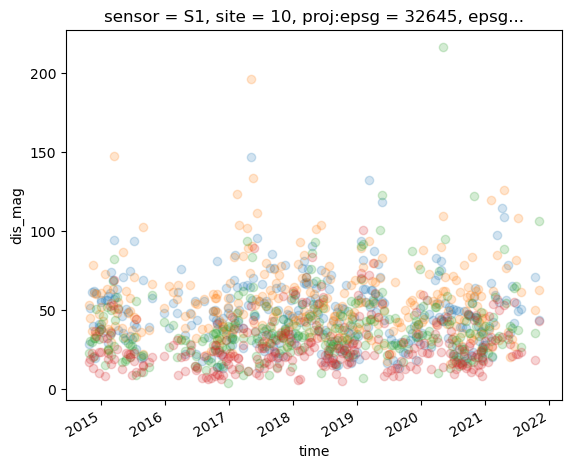

In [39]:
(ds_03976.where(ds_03976.z0.notnull(), drop=True).dis_mag*365).mean(dim=['x','y']).plot(alpha=0.2, marker='o', linestyle='None')
(ds_03976.where(ds_03976.z1.notnull(), drop=True).dis_mag*365).mean(dim=['x','y']).plot(alpha=0.2, marker='o', linestyle='None')
(ds_03976.where(ds_03976.z2.notnull(), drop=True).dis_mag*365).mean(dim=['x','y']).plot(alpha=0.2, marker='o', linestyle='None')
(ds_03976.where(ds_03976.z3.notnull(), drop=True).dis_mag*365).mean(dim=['x','y']).plot(alpha=0.2, marker='o', linestyle='None')

In [411]:
winter_z0_dismag = groupby_03976.where(groupby_03976.z1.notnull(), drop=True).sel(season='DJF').dis_mag.mean(dim=['x','y']).compute().data*365
spring_z0_dismag = groupby_03976.where(groupby_03976.z1.notnull(), drop=True).sel(season='MAM').dis_mag.mean(dim=['x','y']).compute().data*365
summer_z0_dismag = groupby_03976.where(groupby_03976.z1.notnull(), drop=True).sel(season='JJA').dis_mag.mean(dim=['x','y']).compute().data*365
fall_z0_dismag = groupby_03976.where(groupby_03976.z1.notnull(), drop=True).sel(season='SON').dis_mag.mean(dim=['x','y']).compute().data*365

print(winter_z0_dismag)
print(spring_z0_dismag)
print(summer_z0_dismag)
print(fall_z0_dismag)

49.01688174578074
58.84126650363933
52.13552099430868
48.82556403973669


In [361]:
print(retreat_03976_ds.where(retreat_03976_ds.z0.notnull(), drop=True).dis_mag.mean(dim=['x','y','time']).compute().data*365)
print(retreat_03976_ds.where(retreat_03976_ds.z1.notnull(), drop=True).dis_mag.mean(dim=['x','y','time']).compute().data*365)
print(retreat_03976_ds.where(retreat_03976_ds.z2.notnull(), drop=True).dis_mag.mean(dim=['x','y','time']).compute().data*365)
print(retreat_03976_ds.where(retreat_03976_ds.z3.notnull(), drop=True).dis_mag.mean(dim=['x','y','time']).compute().data*365)

45.30674327578146
52.206323957787
36.01065521264687
26.98912238155708


In [338]:
z0_ds = xr.where(retreat_03976_ds.z0.notnull(), retreat_03976_ds, np.nan)
z1_ds = xr.where(retreat_03976_ds.z1.notnull(), retreat_03976_ds, np.nan)
z2_ds = xr.where(retreat_03976_ds.z2.notnull(), retreat_03976_ds, np.nan)
z3_ds = xr.where(retreat_03976_ds.z3.notnull(), retreat_03976_ds, np.nan)



In [344]:
z0_new = z0_ds.where(z0_ds.z0.notnull(), drop=True)
z1_new = z1_ds.where(z1_ds.z1.notnull(), drop=True)
z2_new = z2_ds.where(z2_ds.z2.notnull(), drop=True)
z3_new = z3_ds.where(z3_ds.z3.notnull(), drop=True)

In [348]:
z0_new.x.max()

<xarray.DataArray 'x' ()>
array(309400.)
Coordinates:
    site         <U2 '10'
    sensor       <U2 'S1'
    proj:epsg    int64 32645
    epsg         int64 32645
    spatial_ref  int64 0
    crs          int64 0

In [349]:
z1_new.x.min()

<xarray.DataArray 'x' ()>
array(308400.)
Coordinates:
    site         <U2 '10'
    sensor       <U2 'S1'
    proj:epsg    int64 32645
    epsg         int64 32645
    spatial_ref  int64 0
    crs          int64 0

In [347]:
ds_full = xr.combine_by_coords([z0_new, z1_new, z2_new, z3_new])

ValueError: cannot reindex or align along dimension 'y' because the (pandas) index has duplicate values

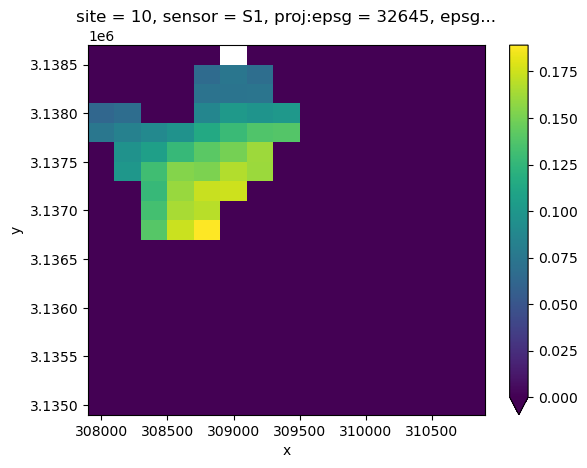

In [307]:
z0_vv.mean(dim='time').plot(vmin=0)

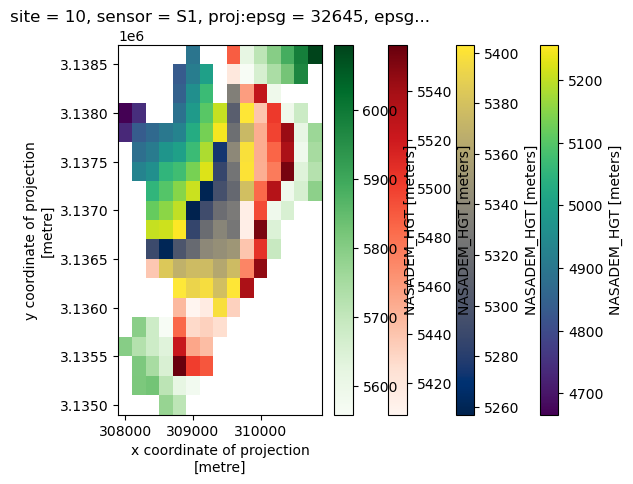

In [271]:
fig, ax = plt.subplots()
retreat_03976_ds.z0.plot(ax=ax)
retreat_03976_ds.z1.plot(ax=ax, cmap='cividis')
retreat_03976_ds.z2.plot(ax=ax, cmap='Reds')
retreat_03976_ds.z3.plot(ax=ax, cmap='Greens')

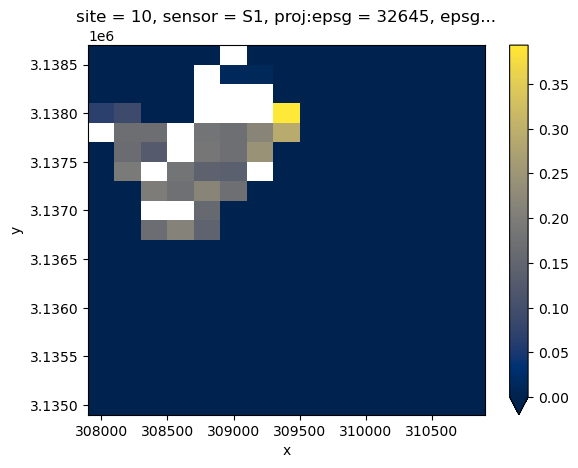

In [298]:
fig, ax = plt.subplots()
xr.where(retreat_03976_ds.z0.notnull(), retreat_03976_ds.dis_mag, -999.).isel(time=4).plot(ax=ax, vmin=0, cmap='cividis')
#xr.where(retreat_03976_ds.z1.notnull(), retreat_03976_ds.dis_mag, -999.).isel(time=1).plot(ax=ax, vmin=0)
#xr.where(retreat_03976_ds.z2.notnull(), retreat_03976_ds.dis_mag, -999.).isel(time=1).plot(ax=ax, vmin=0, cmap='cividis')
#xr.where(retreat_03976_ds.z3.notnull(), retreat_03976_ds.dis_mag, -999.).isel(time=1).plot(ax=ax, vmin=0, cmap='cividis')



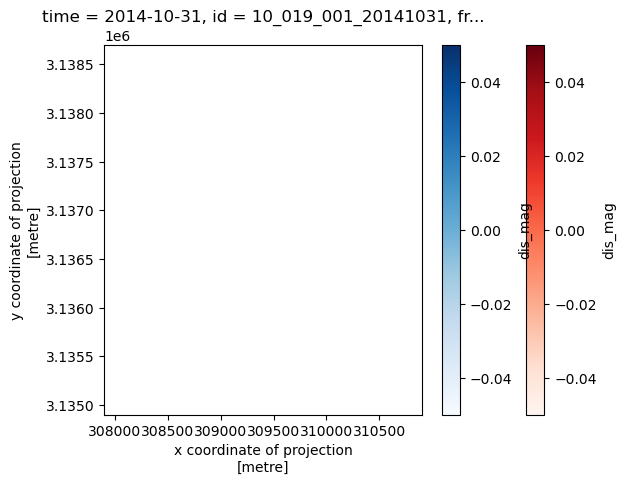

In [281]:
fig, ax = plt.subplots()
retreat_03976_ds.isel(time=1).where(retreat_03976_ds.z1 < 0).dis_mag.plot(ax=ax, cmap='Reds')
retreat_03976_ds.isel(time=1).where(retreat_03976_ds.z2 < 0).dis_mag.plot(ax=ax, cmap='Blues')

In [261]:
retreat_03976_ds.z0.plot(ax=ax)


In [239]:
z1 = dem_03976_downsamp.NASADEM_HGT.where(np.logical_and(dem_03976_downsamp.NASADEM_HGT >= 5256.25, dem_03976_downsamp.NASADEM_HGT <= 5405.), drop=True)


In [72]:
retreat_03976['z'] = (('y','x'), dem_03976_downsamp.NASADEM_HGT.data)

In [215]:
retreat_03976_ds

<xarray.Dataset>
Dimensions:      (time: 314, y: 19, x: 15, band: 5)
Coordinates: (12/18)
  * time         (time) datetime64[ns] 2014-10-23 2014-10-31 ... 2021-11-05
    id           (time) <U19 '10_085_002_20141023' ... '10_019_085_20211105'
  * x            (x) float64 3.08e+05 3.082e+05 ... 3.106e+05 3.108e+05
  * y            (y) float64 3.139e+06 3.138e+06 ... 3.135e+06 3.135e+06
    frame        (time) <U3 '085' '019' '019' '085' ... '019' '019' '019' '019'
    orbit        (time) <U3 '002' '001' '010' '002' ... '085' '085' '085' '085'
    ...           ...
    sec_date     (time) <U15 'S1_20141104T122' ... '20211111T001930'
    title        (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
    proj:epsg    int64 32645
    epsg         int64 32645
    spatial_ref  int64 0
    z            (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Dimensions without coordinates: band
Data variables:
    dis_ang      (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_az       (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_mag      (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_N_ang    (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_r        (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    resolution:  200.0

In [221]:
np.nanpercentile(retreat_03976_ds.z.data, 50)

5405.0

In [220]:
retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z <= 5405., retreat_03976.z >= 5256.25),  drop=True).z.max()

<xarray.DataArray 'z' ()>
array(5536., dtype=float32)
Coordinates:
    site         <U2 '10'
    sensor       <U2 'S1'
    proj:epsg    int64 32645
    epsg         int64 32645
    spatial_ref  int64 0

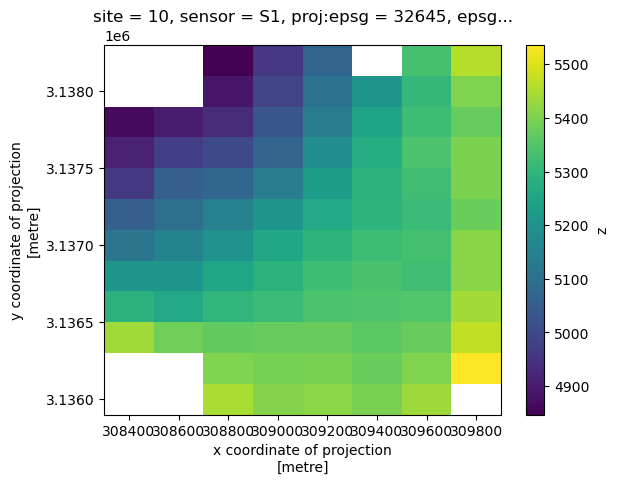

In [223]:
retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z <= 5405., retreat_03976.z >= 5256.25),  drop=True).z.plot()

In [207]:
z0_condition = retreat_03976_ds.z <= 5256.25

In [208]:
z0_subset = retreat_03976_ds.sel(z = z0_condition)

KeyError: "no index found for coordinate 'z'"

In [192]:
zmin = np.nanmin(retreat_03976['z'].data)
zq1 = np.nanpercentile(retreat_03976['z'].data, 25)
zmed = np.nanmedian(retreat_03976['z'].data)
zq3 = np.nanpercentile(retreat_03976['z'].data, 75)
zmax = np.nanmax(retreat_03976['z'].data)

print(zmin)
print(zq1)
print(zmed)
print(zq3)
print(zmax)
    
#define z groups
z_group0 = retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z >= zmin, retreat_03976_ds.z < 5337), drop=True)
#z_group1 = retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z > 5256.25, retreat_03976_ds.z <= 5405.), drop=True)
#z_group2 = retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z > 5405, retreat_03976_ds.z <= 5559.), drop=True)
#z_group3 = retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z > 5559., retreat_03976_ds.z <= zmax), drop=True)

4666.0
5256.25
5405.0
5559.0
6094.0


In [193]:
z_group0.z.max()

<xarray.DataArray 'z' ()>
array(5488., dtype=float32)
Coordinates:
    site         <U2 '10'
    sensor       <U2 'S1'
    proj:epsg    int64 32645
    epsg         int64 32645
    spatial_ref  int64 0

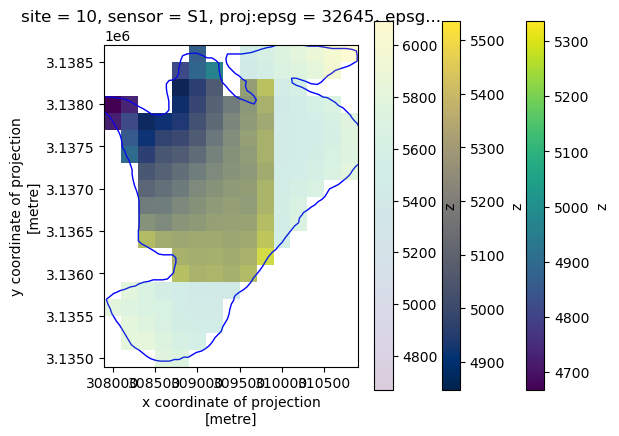

In [187]:
fig, ax = plt.subplots()

z_group0.z.plot(ax=ax)

z_group1.z.plot(ax=ax, cmap='cividis')

rgi_03976.plot(ax=ax, facecolor='None', edgecolor='Blue')
retreat_03976_ds.z.plot(ax=ax, alpha = 0.2)

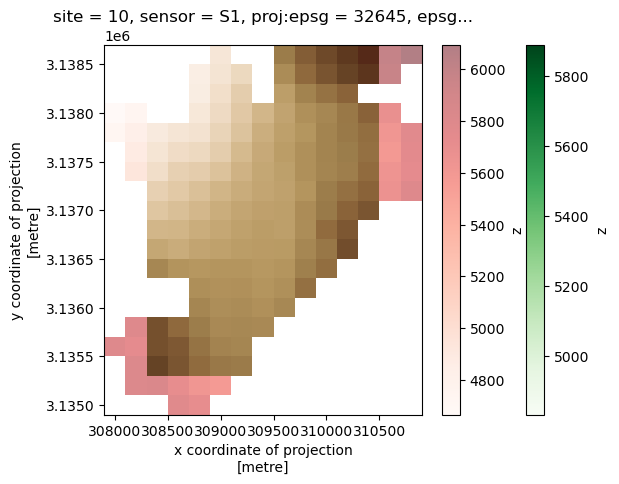

In [161]:
fig, ax = plt.subplots() 

retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z >= 5405, retreat_03976_ds.z <= 5559), drop=True).z.plot(ax=ax, cmap='Greens')
#retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z >= 5256.25, retreat_03976_ds.z <= 5405), drop=True).z.plot(ax=ax, cmap='cividis')
#retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z >= 4666., retreat_03976_ds.z <= 5256.25), drop=True).z.plot(ax=ax)

retreat_03976_ds.z.plot( alpha = 0.5, ax=ax, cmap='Reds')


In [78]:
import numpy as np
np.nanmedian(retreat_03976.z)

5405.0

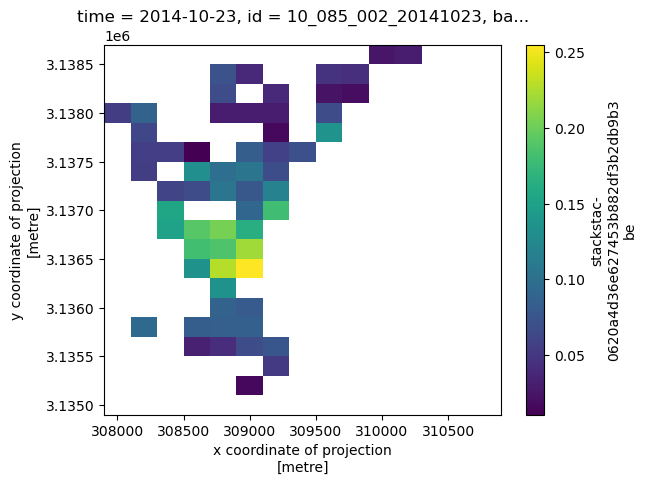

In [52]:
retreat_03976.isel(time=0).sel(band='dis_mag').plot()